## model try


### Load libraries

In [1]:
from cv2 import cv2
import os
import json
import time

import pathlib
from torch.utils.data import DataLoader
import sys
sys.path.append('../')
from src.data.my_dataset import XRayDataSet
from src.data.my_dataset import collate_fn
from tqdm import tqdm

#for model
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead, RegionProposalNetwork
from torchvision.models.detection.faster_rcnn import *
import torch

In [5]:
print(os.getcwd())  

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks


In [6]:
dataset = XRayDataSet(pathlib.Path('../literature/Other/supervisely/wrist/train_pickles'))

In [7]:
training_dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4,collate_fn=collate_fn)

In [8]:
images , targets = next(iter(training_dataloader))

In [9]:
images

(tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]]),
 tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]]))

In [2]:
def get_model_instance_segmentation(num_classes):
      
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [11]:
model = get_model_instance_segmentation(3)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [12]:
model.train()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [14]:
#dummy boxes and images format
images, boxes = torch.rand(1, 3, 600, 1200), torch.rand(1, 2, 4) 
labels = torch.randint(1, 91, (1, 2))
images = list(image for image in images)
targets = []
for i in range(len(images)):
    d = {}
    d['boxes'] = boxes[i]
    d['labels'] = labels[i]
    targets.append(d)

## Real try of the Model

In [3]:
# train on the GPU or on the CPU, if a GPU is not available
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [4]:
#keep only predictions with score higher than the threshold
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    print(preds)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : 
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [5]:
#load train data
train_dataset = XRayDataSet(pathlib.Path('../literature/Other/supervisely/wrist/pickle_data'))
training_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4,collate_fn=collate_fn)

#load validation data
validation_dataset = XRayDataSet(pathlib.Path('../literature/Other/supervisely/wrist/validation_pickles'))
validation_dataloader = DataLoader(validation_dataset, batch_size=2, shuffle=False, num_workers=4,collate_fn=collate_fn)

#load test data
test_dataset = XRayDataSet(pathlib.Path('../literature/Other/supervisely/wrist/test_pickles'))
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=4,collate_fn=collate_fn)

In [6]:
model = get_model_instance_segmentation(3)

In [8]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)

num_epochs = 10

In [22]:
print('----------------------train started--------------------------')

for epoch in range(num_epochs):
    start = time.time()
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in tqdm(training_dataloader):
        i += 1
        
        imgs =list(img.squeeze(dim=0).to(device) for img in imgs)
        annotations = [{k: v for k, v in t[0].items()} for t in annotations]

        ####-----------MOVE annotations to device---------------#####

        # Iterate over the list of dicts and move each tensor to the device
        for annotation in annotations:
            for key, value in annotation.items():
                if isinstance(value, torch.Tensor):
                    annotation[key] = value.to(device)
        
        ####-----------MOVE annotations to device---------------#####


        loss_dict = model(imgs, annotations) 
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        epoch_loss += losses
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

print('----------------------train ended--------------------------')

----------------------train started--------------------------


  0%|          | 0/10 [00:10<?, ?it/s]


RuntimeError: DataLoader worker (pid(s) 17428, 2848, 19412, 6128) exited unexpectedly

In [79]:
#save the model state
torch.save(model.state_dict(),f'my_first_model.pt')


## Model Testing

In [7]:
#load test data
test_dataset = XRayDataSet(pathlib.Path('../literature/Other/supervisely/wrist/test_pickles'))
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=1,collate_fn=collate_fn)

In [19]:
#load the model state

model = get_model_instance_segmentation(3)
model.load_state_dict(torch.load(f'my_first_model.pt',map_location=torch.device('cpu')))


<All keys matched successfully>

In [10]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

def plot_image_from_output(img, annotation):
    
    img = img.cpu().permute(1,2,0)
    
    fig,ax = plt.subplots(1)
    ax.imshow(img,cmap='gray')
    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx].detach().numpy()

        if annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 2 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

In [24]:
#make a single prediction based on the train
with torch.no_grad(): 
    # batch size of the test set = 2
    for imgs, annotations in test_dataloader:
        imgs = list(img.squeeze(dim=0) for img in imgs)

        model.eval()

        pred = make_prediction(model, imgs, threshold = 0.1)
        

[{'boxes': tensor([[478.8079,  96.8675, 521.0992, 168.2464],
        [471.1464,  75.4242, 515.7393, 148.4656]]), 'labels': tensor([2, 2]), 'scores': tensor([0.0524, 0.0500])}]
[{'boxes': tensor([[ 517.5782, 1032.7249,  548.2688, 1069.0245],
        [  46.6126, 1034.7902,   76.9252, 1073.2703],
        [ 514.4083, 1042.4022,  544.9802, 1078.7648]]), 'labels': tensor([2, 2, 2]), 'scores': tensor([0.0645, 0.0547, 0.0523])}]
[{'boxes': tensor([[502.7681,  85.8491, 546.7512, 162.2919]]), 'labels': tensor([2]), 'scores': tensor([0.0501])}]
[{'boxes': tensor([[ 38.0739, 608.3450,  63.5054, 640.4083],
        [ 32.4669, 578.2682,  76.7204, 641.3101],
        [537.0625, 593.7674, 563.3991, 625.2963],
        [534.1592, 602.0011, 560.5455, 633.7413],
        [ 39.5010, 598.5244,  65.6942, 631.0235]]), 'labels': tensor([2, 2, 2, 2, 2]), 'scores': tensor([0.0564, 0.0551, 0.0542, 0.0515, 0.0511])}]
[{'boxes': tensor([[498.0646,  74.3941, 530.5534, 129.2135],
        [492.1789,  57.9255, 526.4359, 1

KeyboardInterrupt: 

In [20]:
model.eval()
images , targets = next(iter(test_dataloader))
imgs = list(img.squeeze(dim=0) for img in images)
predictions = model(imgs)

In [21]:
predictions

[{'boxes': tensor([[478.8079,  96.8675, 521.0992, 168.2464],
          [471.1464,  75.4242, 515.7393, 148.4656]], grad_fn=<StackBackward0>),
  'labels': tensor([2, 2]),
  'scores': tensor([0.0524, 0.0500], grad_fn=<IndexBackward0>)}]

Target :  tensor([2, 1, 1])


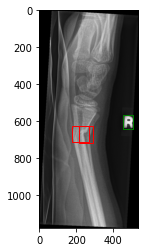

In [22]:
print("Target : ",targets[0][0]['labels'])
plot_image_from_output(images[0][0], targets[0][0])

Prediction :  tensor([2, 2])


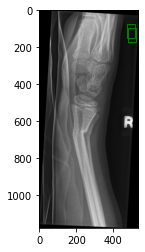

In [23]:
print("Prediction : ", predictions[0]['labels'])
plot_image_from_output(images[0][0],predictions[0])

In [51]:
import torch
print(torch.__version__)

1.11.0


In [41]:
import torch

# load the pickled object
filename = "../losses.pickle"
loaded_object = torch.load(filename, map_location=torch.device('cpu'))



RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
#plot validation loss over training
plt.plot(list(range(0,epochs)), train_loss, color='blue', label='Train loss')
plt.plot(list(range(0,epochs)), val_loss, color = 'red', label='Validation loss')
plt.legend()

In [25]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)

In [26]:
lr_scheduler